# 🐦 Zero-Shot BirdDetector — Initial Exploration

### 1. Setup

In [1]:
from deepforest import main, visualize
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import torch
import cv2

/Users/shraddharamesh/GitHub Projects/avian-ai-lab/projects/bird-detector-lab/birdlab-env/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


### 2. Load the Model

In [ ]:
model = main.deepforest()

# Load weights from Hugging Face
url = "https://huggingface.co/weecology/deepforest-bird/resolve/main/bird.pt"
state_dict = torch.hub.load_state_dict_from_url(url, map_location="cpu")
model.model.load_state_dict(state_dict)

model.config["model"]["class_names"] = ["bird"]   
model.label_dict = {"bird": 0}
model.label_dict_reverse = {0: "bird"}

print("Loaded BirdDetector model. Labels:", model.label_dict)

Reading config file: /Users/shraddharamesh/GitHub Projects/avian-ai-lab/projects/bird-detector-lab/birdlab-env/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


/Users/shraddharamesh/GitHub Projects/avian-ai-lab/projects/bird-detector-lab/birdlab-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shraddharamesh/GitHub Projects/avian-ai-lab/projects/bird-detector-lab/birdlab-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded BirdDetector model. Labels: {'bird': 0}


### 3. Load a Sample Drone Image

(-0.5, 298.5, 167.5, -0.5)

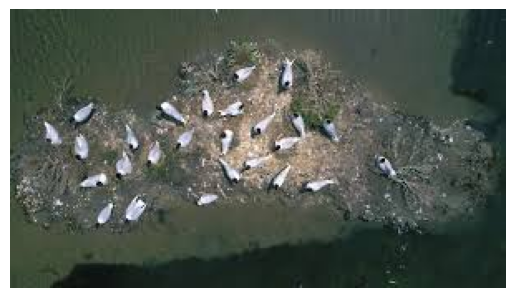

In [3]:
image = cv2.imread("../data/sample_images/bird1.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")

### 4. Run Prediction

In [4]:
predictions = model.predict_image(image=image)
predictions.head()

/Users/shraddharamesh/GitHub Projects/avian-ai-lab/projects/bird-detector-lab/birdlab-env/lib/python3.10/site-packages/deepforest/predict.py:34: UserWarning: Image type is uint8, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn(f"Image type is {image.dtype}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")


,xmin,ymin,xmax,ymax,label,score
0,36.0,55.0,51.0,72.0,Tree,0.610993
1,131.0,30.0,149.0,46.0,Tree,0.499877
2,49.0,114.0,65.0,131.0,Tree,0.489447
3,36.0,74.0,51.0,92.0,Tree,0.479486
4,218.0,86.0,234.0,102.0,Tree,0.471605


### 5. Visualize Predictions

In [ ]:
visualize.plot_predictions(image, predictions)

### 6. Evaluate (Basic)

If dataset has boxes or points.

### 7. Notes + Observations

You will write:
- How well zero-shot works
- What birds it misses
- Where false positives happen
- Habitat patterns
